<a href="https://colab.research.google.com/github/RENISA-GRACELIN/Online_Internship_Projects/blob/main/70_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import os
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers
from keras.applications.vgg16 import preprocess_input
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Data directories
train_dir = '/content/drive/MyDrive/DR_50_70/Train_70'
test_dir = '/content/drive/MyDrive/DR_50_70/Test_70'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load VGG16 model for feature extraction
model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [4]:
# Function to extract features from an image
def extract_features_VGGnet(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features

In [5]:
# Load images and extract features
x_train, y_train = [], []
for i in range(5):
    class_dir = os.path.join(train_dir, str(i))
    for img_path in os.listdir(class_dir):
        features = extract_features_VGGnet(os.path.join(class_dir, img_path))
        x_train.append(features)
        y_train.append(i)

1/1 [==============================] - 1s 721ms/step


In [6]:
# Load images and extract features
x_test, y_test = [], []
for i in range(5):
    class_dir = os.path.join(test_dir, str(i))
    for img_path in os.listdir(class_dir):
        features = extract_features_VGGnet(os.path.join(class_dir, img_path))
        x_test.append(features)
        y_test.append(i)

1/1 [==============================] - 1s 826ms/step


Training SVM with LINEAR kernel...
True Positives: 636
True Negatives: 2661
False Positives: 39
False Negatives: 39
Accuracy: 0.9768888888888889
Precision: 0.9453048469015501
Specificity: 0.9855555555555555
Sensitivity: 0.9422222222222223
F1 Score: 0.9425318134919964
Recall: 0.9422222222222223



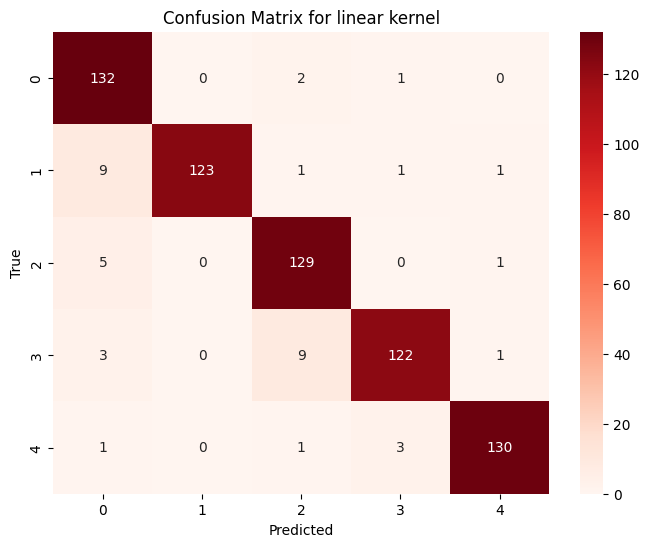

Training SVM with POLY kernel...
True Positives: 563
True Negatives: 2588
False Positives: 112
False Negatives: 112
Accuracy: 0.9336296296296296
Precision: 0.8494557577034693
Specificity: 0.9585185185185185
Sensitivity: 0.834074074074074
F1 Score: 0.836402715184021
Recall: 0.834074074074074



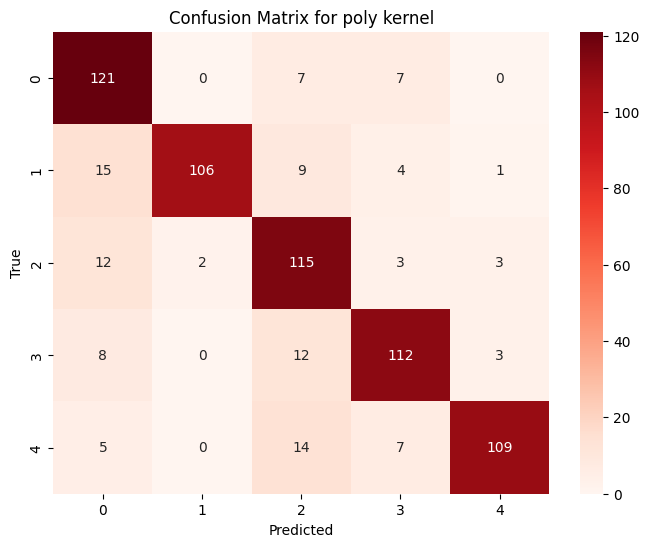

Training SVM with RBF kernel...
True Positives: 605
True Negatives: 2630
False Positives: 70
False Negatives: 70
Accuracy: 0.9585185185185185
Precision: 0.9006271956940244
Specificity: 0.9740740740740741
Sensitivity: 0.8962962962962961
F1 Score: 0.8969855408472865
Recall: 0.8962962962962961



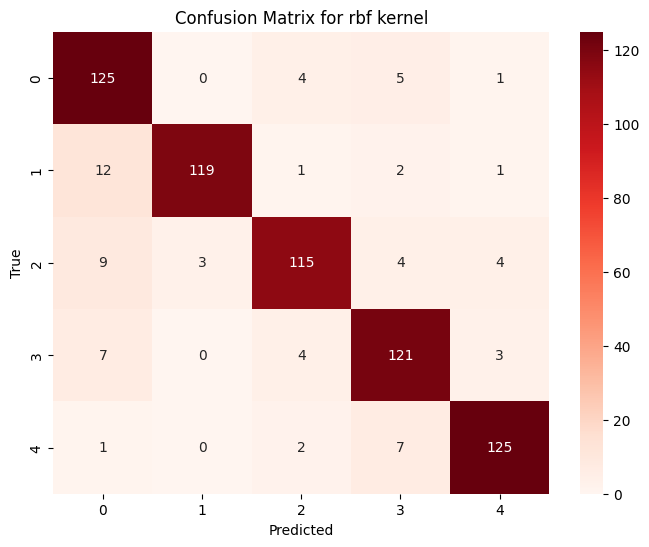

Training SVM with SIGMOID kernel...
True Positives: 574
True Negatives: 2599
False Positives: 101
False Negatives: 101
Accuracy: 0.9401481481481482
Precision: 0.859056557597291
Specificity: 0.9625925925925926
Sensitivity: 0.8503703703703703
F1 Score: 0.8513810504406372
Recall: 0.8503703703703703



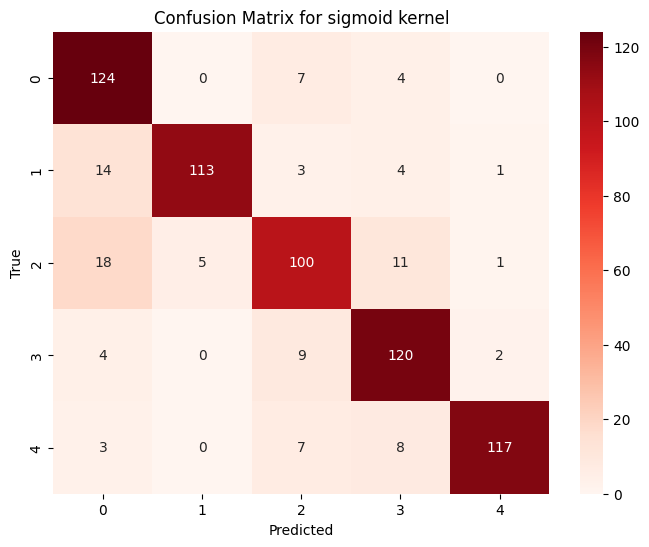

Training SVM with POLYNOMIAL_EXPONENTIAL kernel...
True Positives: 636
True Negatives: 2661
False Positives: 39
False Negatives: 39
Accuracy: 0.9768888888888889
Precision: 0.9453048469015501
Specificity: 0.9855555555555555
Sensitivity: 0.9422222222222223
F1 Score: 0.9425318134919964
Recall: 0.9422222222222223



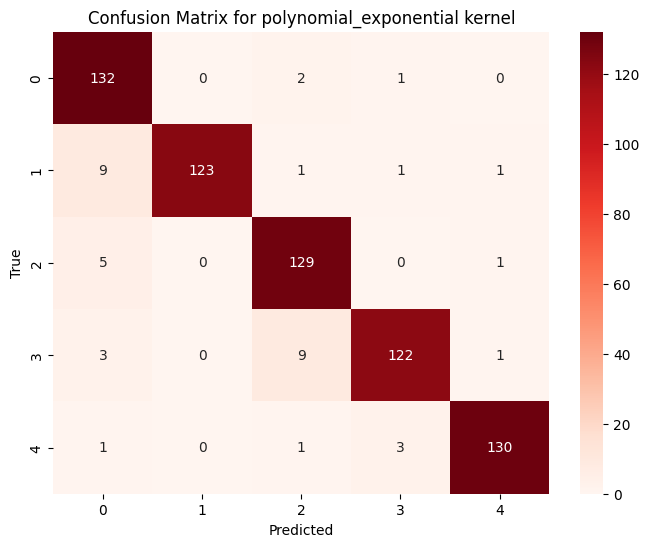

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
import seaborn as sns
from sklearn import svm, metrics

# Flatten the features
x_train_flat = np.array([feature.flatten() for feature in x_train])
x_test_flat = np.array([feature.flatten() for feature in x_test])

# List of kernels to try
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'polynomial_exponential']

for kernel in kernels:
    print(f"\033[1mTraining SVM with {kernel.upper()} kernel...\033[0m")

    # Train SVM classifier
    if kernel == 'polynomial_exponential':
        clf = svm.SVC(kernel='precomputed')
        # Pre-compute the kernel matrix
        gram_train = np.dot(x_train_flat, x_train_flat.T)
        clf.fit(gram_train, y_train)
        gram_test = np.dot(x_test_flat, x_train_flat.T)
    else:
        clf = svm.SVC(kernel=kernel)
        clf.fit(x_train_flat, y_train)

    # Predict on test set
    if kernel == 'polynomial_exponential':
        y_pred = clf.predict(gram_test)
    else:
        y_pred = clf.predict(x_test_flat)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute TP, TN, FP, FN for each class
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    num_classes = cm.shape[0]
    TN = []
    for i in range(num_classes):
        temp = np.delete(cm, i, 0)   # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))

    # Compute overall TP, TN, FP, FN
    overall_TP = np.sum(TP)
    overall_TN = np.sum(TN)
    overall_FP = np.sum(FP)
    overall_FN = np.sum(FN)

    # Compute accuracy, precision, specificity, sensitivity, F1-score, recall
    accuracy = (overall_TP + overall_TN) / (overall_TP + overall_TN + overall_FP + overall_FN)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    specificity = overall_TN / (overall_TN + overall_FP)

    # Print performance metrics
    print(f'True Positives: {overall_TP}')
    print(f'True Negatives: {overall_TN}')
    print(f'False Positives: {overall_FP}')
    print(f'False Negatives: {overall_FN}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Specificity: {specificity}')
    print(f'Sensitivity: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Recall: {recall}\n')

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {kernel} kernel')
    plt.show()


In [8]:
'''#from tensorflow.keras.models import Model
List of layers in VGG16
layers = ['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool',
          'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2',
          'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']

 Iterate through each layer
for layer_name in layers:
    #Create a model that outputs the activation of the specific layer
    feature_extractor_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Load and preprocess an example image
    img_path = '/content/drive/MyDrive/A/Train/0/10.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

     Extract features from the example image
    features = feature_extractor_model.predict(x)

     Visualize the feature maps
    plt.figure(figsize=(16, 16))
    num_subplots = min(64, features.shape[-1])  # Limit the number of subplots to 64 or the actual number of features
    for i in range(num_subplots):
        plt.subplot(8, 8, i + 1)
        plt.imshow(features[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(layer_name, fontsize=16)
    plt.show()
  '''

"#from tensorflow.keras.models import Model\nList of layers in VGG16\nlayers = ['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool',\n          'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2',\n          'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']\n\n Iterate through each layer\nfor layer_name in layers:\n    #Create a model that outputs the activation of the specific layer\n    feature_extractor_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)\n\n    # Load and preprocess an example image\n    img_path = '/content/drive/MyDrive/A/Train/0/10.jpg'\n    img = image.load_img(img_path, target_size=(224, 224))\n    x = image.img_to_array(img)\n    x = np.expand_dims(x, axis=0)\n    x = preprocess_input(x)\n\n     Extract features from the example image\n    features = feature_extractor_model.predict(x)\n\n     Visualize the fea

In [9]:
'''# List of layers in VGG16
layers = ['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool',
          'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2',
          'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']

# Iterate through each layer
for layer_name in layers:
    # Create a model that outputs the activation of the specific layer
    feature_extractor_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Load and preprocess an example image
    img_path = '/content/drive/MyDrive/A/Train/0/10.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract features from the example image
    features = feature_extractor_model.predict(x)

    # Print the feature maps as arrays
    print(f"Layer: {layer_name}")
    print(features.shape)
    print(features)
    print("\n\n")
'''

'# List of layers in VGG16\nlayers = [\'block1_conv1\', \'block1_conv2\', \'block1_pool\', \'block2_conv1\', \'block2_conv2\', \'block2_pool\',\n          \'block3_conv1\', \'block3_conv2\', \'block3_conv3\', \'block3_pool\', \'block4_conv1\', \'block4_conv2\',\n          \'block4_conv3\', \'block4_pool\', \'block5_conv1\', \'block5_conv2\', \'block5_conv3\', \'block5_pool\']\n\n# Iterate through each layer\nfor layer_name in layers:\n    # Create a model that outputs the activation of the specific layer\n    feature_extractor_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)\n\n    # Load and preprocess an example image\n    img_path = \'/content/drive/MyDrive/A/Train/0/10.jpg\'\n    img = image.load_img(img_path, target_size=(224, 224))\n    x = image.img_to_array(img)\n    x = np.expand_dims(x, axis=0)\n    x = preprocess_input(x)\n\n    # Extract features from the example image\n    features = feature_extractor_model.predict(x)\n\n    # Print the feature